# 1. Set Up Notebook and Load Data 

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import fnmatch
import pickle
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler



# CUSTOM Imports
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

In [3]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist2D*24*minmax*')]
# input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*24*minmax*')]
# input_files = [f for f in files if fnmatch.fnmatch(f, 'hist2D*24*none*')]
# input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*24*none*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

Dropdown(description='TSNE File :', options=('hist2D-Full-nE16-nt24-normminmax.pkl',), value='hist2D-Full-nE16…

In [4]:
# Load features
input_file = input_widget.value
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
ids = list(hist_dict.keys())
histograms = hist_dict.values()
features = np.array([np.array(h) for h in histograms])
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index(drop=True)
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_global = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_properties_global['obsreg_id'] = df_properties_global['obsid'].astype(str) + '_' + df_properties_global['region_id'].astype(str)
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')
# Data
df_label = df_properties.copy()
ID = df_label['obsreg_id'].values
X = features
# Print Summary
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))


Number of Features:  95473
Number of Property Sets:  95473


In [5]:
# Select saved model
files = os.listdir(f'{global_path}/{set_id}/')
encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*2D*CNN*fc[*reg*reg*888-*h5')]
encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*2D*CNN*fc[*neck12*xander*h5')]
encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*2D*CNN*fc[*neck12*xae*h5')]
# encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*3D*FC*fc[*h5')]
encode_widget = widgets.Dropdown(options=encode_files[:],value=encode_files[-1],description='Encoder :',disabled=False,style = {'description_width': 'initial'}); encode_widget 

Dropdown(description='Encoder :', options=('XAE-ENCODER-2D-CNN-cn[32, 16]-fc[192, 48]-neck12-lr0.001-b1024-reg…

In [6]:
e = encode_widget.value
print(e)
encoder_model = tf.keras.models.load_model(f'{global_path}/{set_id}/{e}')
embedding = encoder_model.predict(X)
# embedding = np.array([np.array(e).flatten() for e in embedding])

scaler = StandardScaler()
embedding2 = scaler.fit_transform(embedding)


XAE-ENCODER-2D-CNN-cn[32, 16]-fc[192, 48]-neck12-lr0.001-b1024-reg0.0-botreg0.1-kernhe_normal-xae-rs505.h5
Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

   1/2984 [..............................] - ETA: 10:20

2023-05-15 11:31:27.063443: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2984/2984 [==============================] - 11s 4ms/step


In [7]:
perp = 80
learn_rate = 80
early_exag = 1
iterations = 1500
random_state = 211
init = 'random'
tsne_model = TSNE(n_components = 2, perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init=init, random_state=random_state) # rosanne 78592 #lin 27514
X_tsne = tsne_model.fit_transform(embedding2) 
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne['obsreg_id'] = ID

tsne_name = e[:-3]
tsne_path = f'{global_path}/{set_id}/{tsne_name}-TSNE{init}-lr{learn_rate}-perp{perp}-it{iterations}-ee{early_exag}-rs{random_state}.csv'
df_tsne.to_csv(tsne_path, index=False)

In [52]:
# Select saved model
files = os.listdir(f'{global_path}/{set_id}/')
TSNE_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*2D*CNN*fc[*reg*reg*888*-TSNE*rs*.csv')]
TSNE_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*2D*CNN*fc[*neck*xae*-TSNE*rs*.csv')]
# encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*3D*FC*fc[*h5')]
tsne_widget = widgets.Dropdown(options=TSNE_files[:],value=TSNE_files[-1],description='tsne:',disabled=False,style = {'description_width': 'max-content'}); tsne_widget 

Dropdown(description='tsne:', index=63, options=('XAE-ENCODER-2D-CNN-cn[32, 16]-fc[192, 48]-neck12-lr0.001-b10…

In [53]:
t = f'{global_path}/{set_id}/{tsne_widget.value}'
df_tsne = pd.read_csv(t)
print(t)

flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218']
# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']
ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']
# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
xue = ['957_208', '3389_274','15211_38']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59']
vasquez = ['2025_39','9548_14','15113_59']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015
flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']
NEW = ['23022_122']

tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez = df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding)]
tsne_nandra = df_tsne.loc[df_tsne['obsreg_id'].isin(nandra)]
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares + flares_maybe)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva + dips_maybe)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

tsne_new = df_tsne.loc[df_tsne['obsreg_id'].isin(NEW)] 

/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Full/XAE-ENCODER-2D-CNN-cn[32, 16]-fc[192, 48]-neck12-lr0.001-b1024-reg0.0-botreg0.1-kernhe_normal-xae-rs505-TSNErandom-lr80-perp80-it4000-ee1-rs505.csv


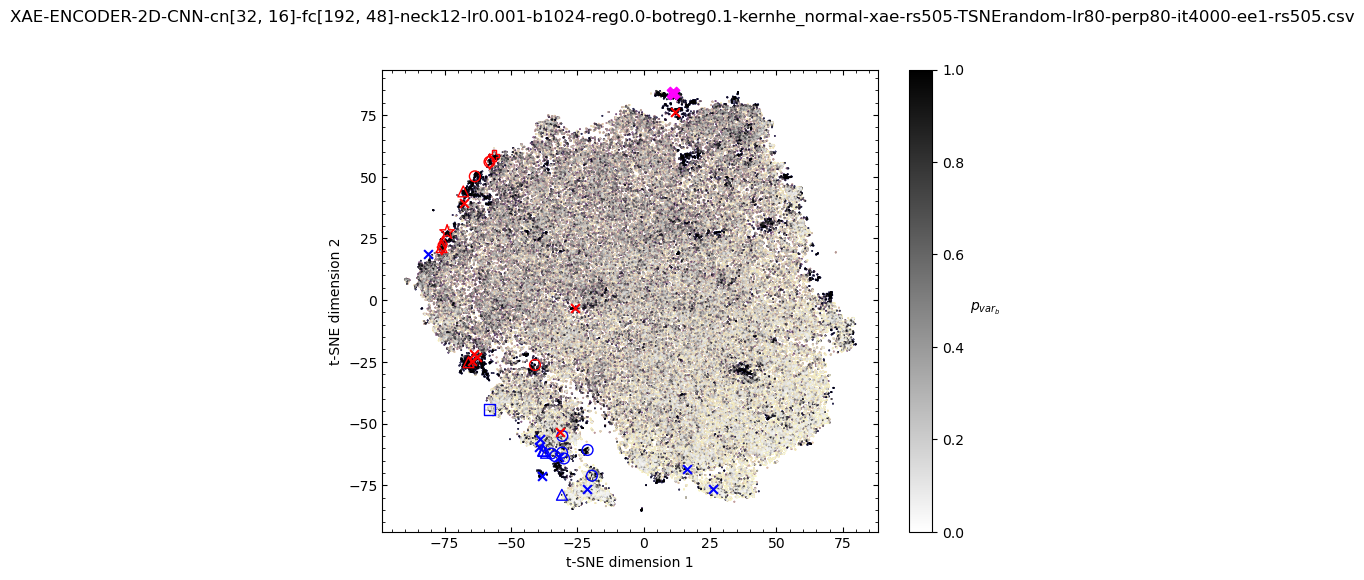

In [54]:
fig, axs = plt.subplots(figsize=(8, 6))
fig.suptitle(tsne_widget.value)
var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_label['var_prob_b'], s=0.1, cmap='plasma_r')
var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_label['var_prob_b'], s=0.1, cmap='binary')
# var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_label['hard_hs'], s=0.1, cmap='plasma_r')
axs.set_xlabel('t-SNE dimension 1')
axs.set_ylabel('t-SNE dimension 2')
axs.grid(False) 
cbar = axs.figure.colorbar(var_b, ax=axs)
cbar.ax.set_ylabel(r'$p_{var_b}$', rotation = 0,labelpad=15)
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)

markersize = 40
c_f = 'red'
c_d = 'blue'

axs.scatter(tsne_distefano['tsne1'], tsne_distefano['tsne2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(tsne_m101ulx['tsne1'], tsne_m101ulx['tsne2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(tsne_parmar['tsne1'], tsne_parmar['tsne2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(tsne_moredips['tsne1'], tsne_moredips['tsne2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
# axs.scatter(tsne_lin['tsne1'], tsne_lin['tsne2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(tsne_vasquez['tsne1'], tsne_vasquez['tsne2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Quirola et al. (2022)')
axs.scatter(tsne_xue['tsne1'], tsne_xue['tsne2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(tsne_nandra['tsne1'], tsne_nandra['tsne2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(tsne_glennie['tsne1'], tsne_glennie['tsne2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(tsne_jonker['tsne1'], tsne_jonker['tsne2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')


axs.scatter(tsne_new['tsne1'], tsne_new['tsne2'], c='magenta', marker='X', s=markersize*2, facecolor='none', label='NEW')

-44.025265 -20.90961


Text(0, 0.5, 'tSNE feature 2')

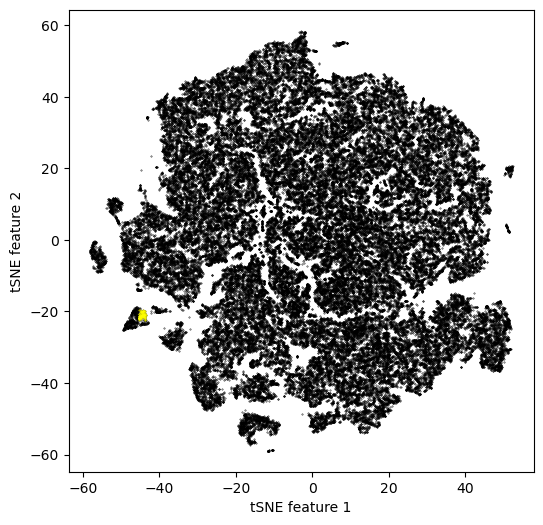

In [99]:
box_size = 1.4

# box = anomalies[anomalies['obsreg_id']=='17743_278']
box = df_tsne[df_tsne['obsreg_id']=='12884_10'] #'10783_10','10871_10','11059_10','9070_10' distefano = ['13814_567'] NEW = ['23022_122'] glennie = ['12884_10'] jonker = ['803_90']
x0, y0 = box[['tsne1']].values[0][0], box[['tsne2']].values[0][0]
print(x0, y0)
xmin, xmax = x0 - box_size, x0 + box_size
ymin, ymax = y0 - box_size, y0 + box_size
points_in_box = df_tsne[(df_tsne['tsne1'] >= xmin) & (df_tsne['tsne1'] <= xmax) & (df_tsne['tsne2'] >= ymin) & (df_tsne['tsne2'] <= ymax)]
potential_anomalies2 = points_in_box['obsreg_id']
df_properties_anomalies2 = df_properties_global[df_properties_global['obsreg_id'].isin(potential_anomalies2)]

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
rej = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'], s=0.1, c='black', label = 'Rejected Clusters')
acc = axs.scatter(points_in_box['tsne1'], points_in_box['tsne2'], s=0.1, c='yellow', label = 'Chosen Clusters')
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')

In [75]:
# 6. Lightcurve Plotter Function
import astropy 
from astropy import stats as astats
def lightcurveplotterNEW(df_eventfiles_input,id_name,bin_size_sec,hr_window=10,bb_p0 = 0.1,band_errors = True):
    """
    DESCRIPTION: Plots lightcurves and cumulative counts for given eventfile input dataframe
    INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
    OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
    """
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    google_purple = '#6f2da8'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(5, 1, figsize=(6, 12),constrained_layout = True)
    fig.suptitle(f'ObsRegID: {id_name}',fontweight="bold")
    # Prepare df
    df = df_eventfiles_input.copy()
    df['time'] = df_eventfiles_input['time'] - min(df_eventfiles_input['time'])
    df = df.sort_values(by='time') 
    df = df.reset_index(drop=True)
    # Create binned lightcurve
    df_binned = df.groupby(df['time'] // bin_size_sec * bin_size_sec).agg(
        broad_count = ('energy', lambda x: ((x >= 500) & (x <= 7000)).sum()),
        soft_count =('energy', lambda x: ((x >= 500) & (x < 1200)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()))
    # Plot binned lightcurve
    axs[0].plot(df_binned.index/1000, df_binned['broad_count'], color = google_blue, marker = 'o', markerfacecolor = 'black', markersize = 4)
    axs[0].set_xlabel('Time [ks]')
    axs[0].set_ylabel('Counts per Bin')
    axs[0].set_title(f'Lightcurve with {bin_size_sec}s Bin Size')
    axs[0].set_xlim([0,max(df["time"]/1000)])
    # Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()
    errors = rolling_std['broad_count']/math.sqrt(3)
    errors.iloc[0] = errors.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors.iloc[-1] = errors.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_h = rolling_std['hard_count']/math.sqrt(3)
    errors_h.iloc[0] = errors_h.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_h.iloc[-1] = errors_h.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_m = rolling_std['medium_count']/math.sqrt(3)
    errors_m.iloc[0] = errors_m.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_m.iloc[-1] = errors_m.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_s = rolling_std['soft_count']/math.sqrt(3)
    errors_s.iloc[0] = errors_s.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_s.iloc[-1] = errors_s.iloc[-1] * math.sqrt(3)/math.sqrt(2)
    # Plot rolling 3-bin averaged lightcurved
    axs[1].plot(df_rolling.index/1000, df_rolling['broad_count'], color = google_red)
    axs[1].errorbar(df_rolling.index/1000, df_rolling['broad_count'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)
    axs[1].set_xlabel('Time [ks]')
    axs[1].set_ylabel('Counts per Bin')
    axs[1].set_title('Running Average of 3 Bins')
    axs[1].set_xlim([0,max(df["time"]/1000)])
    # Create cumulative count plot
    df_cumulative = df.copy()
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Create a BB plot
    bb_bins = astats.bayesian_blocks(df['time'].values/1000, fitness='events',p0 = bb_p0) # p0 = 0.01 or so BASED ON VINAY ! 6?
    bin_widths = bb_bins[1:] - bb_bins[:-1]
    counts, bins =  np.histogram(df['time']/1000, bins=bb_bins)
    countrate = counts/bin_widths 
    bin_centers = (bb_bins[:-1] + bb_bins[1:]) / 2
    axs[3].step(bb_bins, np.append(countrate, countrate[-1]), where='post', color='black')
    axs[3].set_xlim([0,max(df["time"]/1000)])
    # axs[3].set_xlim(axs[1].get_xlim())
    axs[3].set_xlabel('Time [ks]')
    axs[3].set_ylabel('Count Rate')
    axs[3].set_title(f'Bayesian Blocks Count Rate (p0 = {bb_p0})')
    # Create a Energy Band Plot
    axs[2].plot(df_rolling.index/1000, df_rolling['hard_count'], color = google_blue, label='Hard')
    axs[2].plot(df_rolling.index/1000, df_rolling['medium_count'], color = google_green, label='Medium')
    axs[2].plot(df_rolling.index/1000, df_rolling['soft_count'], color = google_red, label='Soft')
    if band_errors == True:
        axs[2].errorbar(df_rolling.index/1000, df_rolling['hard_count'], yerr = errors_h, xerr = None,fmt ='.',color = google_blue,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['medium_count'], yerr = errors_m, xerr = None,fmt ='.',color = google_green,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['soft_count'], yerr = errors_s, xerr = None,fmt ='.',color = google_red,linewidth = 1,capsize = 2)
    axs[2].set_xlim([0,max(df_binned.index/1000)])
    # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    axs[2].set_ylabel('Counts')
    axs[2].set_xlabel('Time [ks]')
    axs[2].set_title(f'Energy Bands with {bin_size_sec}s Bin Size - Running Avg')
    axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    # # Create HR 
    # # Compute the counts for each energy band
    # df['soft_count'] = ((df['energy'] >= 500) & (df['energy'] < 1200)).rolling(hr_window).sum()
    # df['medium_count'] = ((df['energy'] >= 1200) & (df['energy'] < 2000)).rolling(hr_window).sum()
    # df['hard_count'] = ((df['energy'] >= 2000) & (df['energy'] <= 7000)).rolling(hr_window).sum()
    # df[['soft_count', 'medium_count','hard_count']] = df[['soft_count', 'medium_count','hard_count']].shift(-math.floor(hr_window/2))
    # # Compute the HR ratios using the counts
    # df['HR_hs'] = (df['hard_count'] - df['soft_count']) / (df['hard_count'] + df['soft_count'])
    # df['HR_hm'] = (df['hard_count'] - df['medium_count']) / (df['hard_count'] + df['medium_count'])
    # df['HR_ms'] = (df['medium_count'] - df['soft_count']) / (df['medium_count'] + df['soft_count'])

    # axs[4].plot(df["time"]/1000, df['HR_hs'], color = google_blue, label='H-S')
    # axs[4].plot(df["time"]/1000, df['HR_hm'], color = google_green, label='H-M')
    # axs[4].plot(df["time"]/1000, df['HR_ms'], color = google_red, label='M-S')
    # axs[4].set_xlim([0,max(df["time"]/1000)])
    # # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    # axs[4].set_ylabel('HR')
    # axs[4].set_xlabel('Time [ks]')
    # axs[4].set_title(f'Running HR over {hr_window} counts')
    # axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    #Create BB HR
    df_hr_bb = df.copy()
    # compute photon counts in each bin
    df_hr_bb = df_hr_bb.groupby(pd.cut(df_hr_bb['time']/1000, bb_bins)).agg(
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        soft_count=('energy', lambda x: ((x >= 500) & (x < 1200)).sum())
    )
    df_hr_bb["bb_hs"] = (df_hr_bb['hard_count'] - df_hr_bb['soft_count']) / (df_hr_bb['hard_count'] + df_hr_bb['soft_count'])
    df_hr_bb["bb_hm"]  = (df_hr_bb['hard_count'] - df_hr_bb['medium_count']) / (df_hr_bb['hard_count'] + df_hr_bb['medium_count'])
    df_hr_bb["bb_ms"]  = (df_hr_bb['medium_count'] - df_hr_bb['soft_count']) / (df_hr_bb['medium_count'] + df_hr_bb['soft_count'])
    bb_hs = df_hr_bb["bb_hs"].values
    bb_hm = df_hr_bb["bb_hm"].values
    bb_ms = df_hr_bb["bb_ms"].values
    axs[4].step(bb_bins, np.append(bb_hs, bb_hs[-1]), where='post',color = google_blue, label='H-S')
    axs[4].step(bb_bins, np.append(bb_hm, bb_hm[-1]), where='post',color = google_green, label='H-M')
    axs[4].step(bb_bins, np.append(bb_ms, bb_ms[-1]), where='post',color = google_red, label='M-S')
    axs[4].set_xlim([0,max(df["time"]/1000)])
    # axs[5].set_xlim(axs[1].get_xlim())
    axs[4].set_ylabel('HR')
    axs[4].set_xlabel('Time [ks]')
    axs[4].set_title(f'Bayesian Blocks HR')
    axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)
    plt.show()
    return countrate 

17
Name: 2CXO J140828.9-270328, ID: 12884-10, Date: 2011-01-03T19:40:24, Counts: 674
RA  212.12053220774715 DEC  -27.05775444803289
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


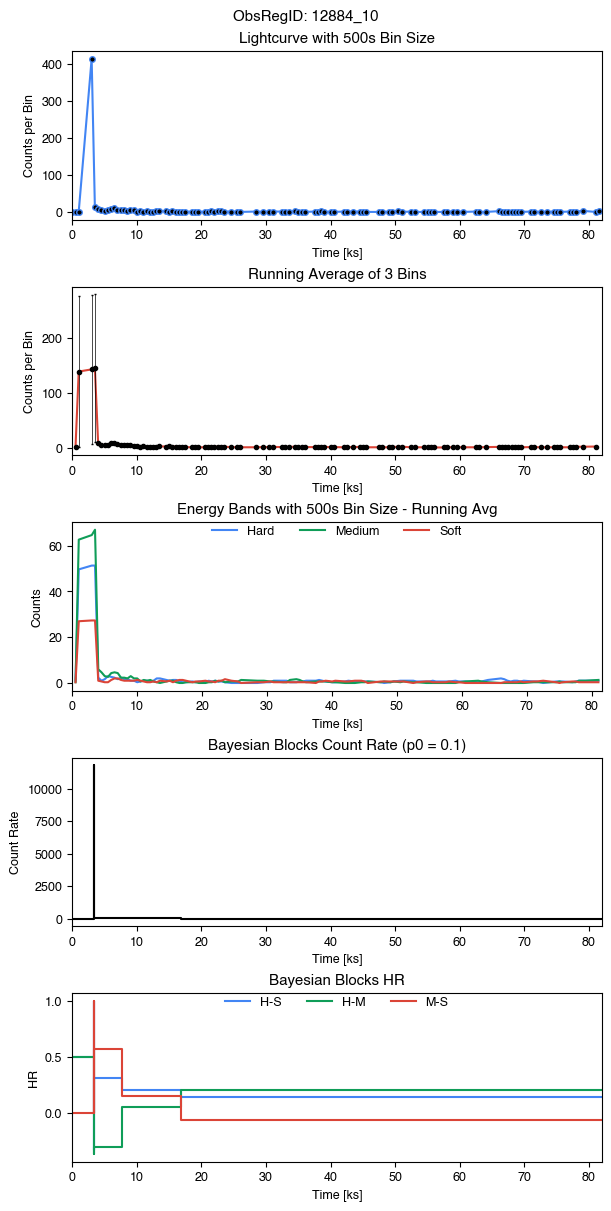

Name: 2CXO J010344.5-214845, ID: 13454-56, Date: 2011-09-19T20:03:04, Counts: 99
RA  15.935707266263648 DEC  -21.81275928059091
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


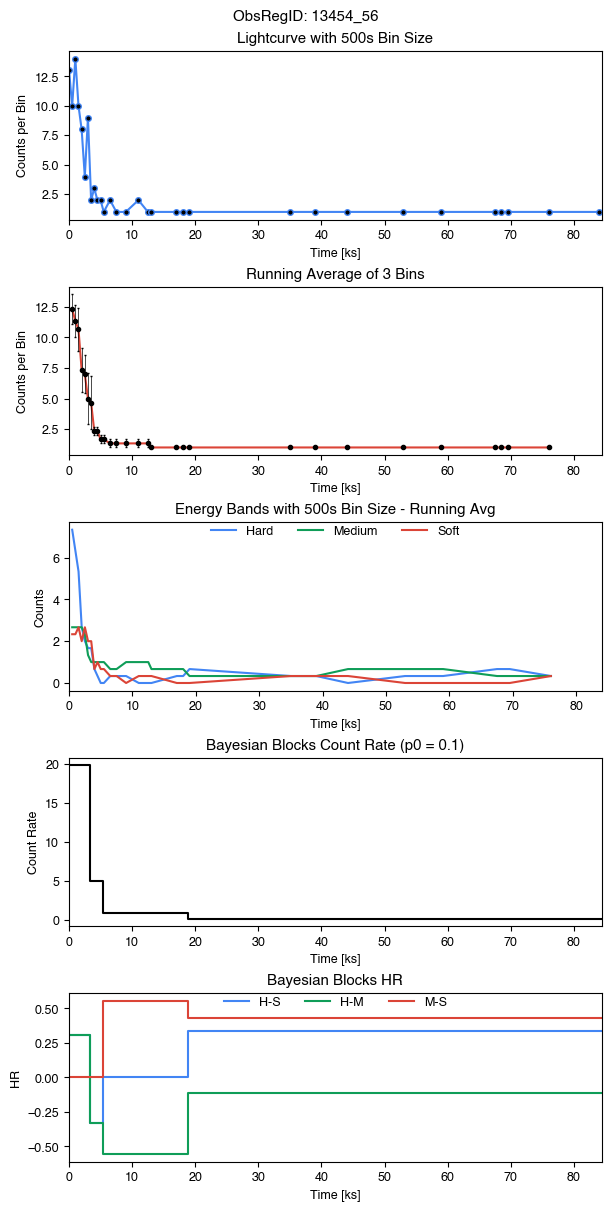

Name: 2CXO J055151.6+323526, ID: 13657-243, Date: 2012-01-15T20:54:41, Counts: 59
RA  87.96511390217654 DEC  32.59070419817034
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


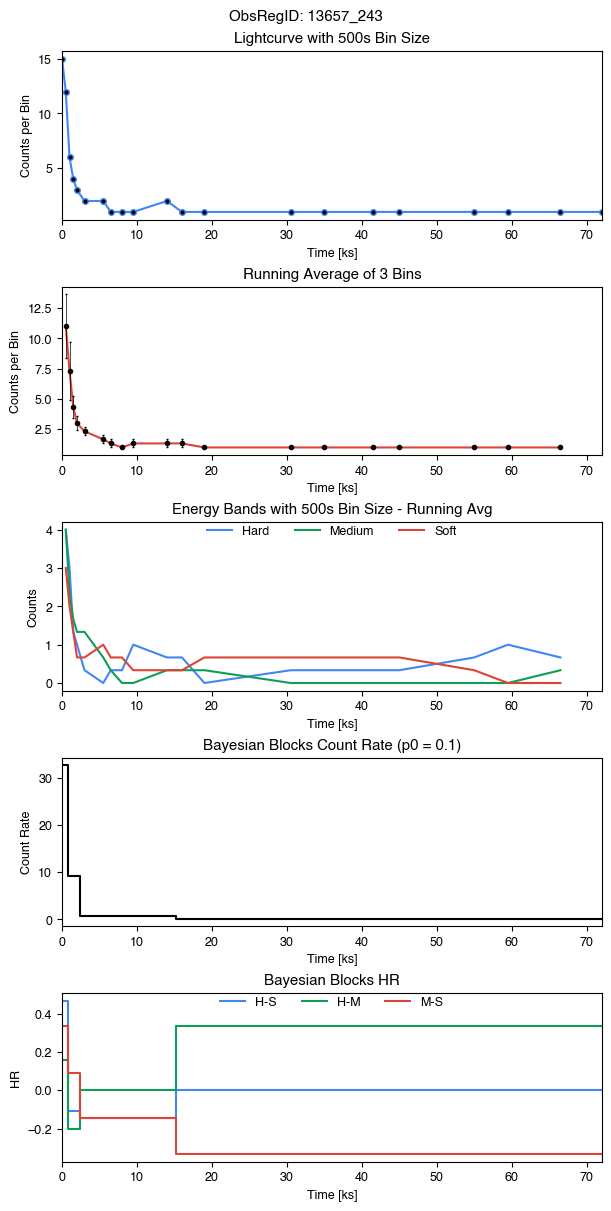

Name: 2CXO J224247.3+530201, ID: 14020-17, Date: 2012-04-21T13:26:48, Counts: 36
RA  340.69722611413647 DEC  53.03359145432785
varB  1.0 varH  nan varM  1.0 varS  1.0 varINDEX  8.0


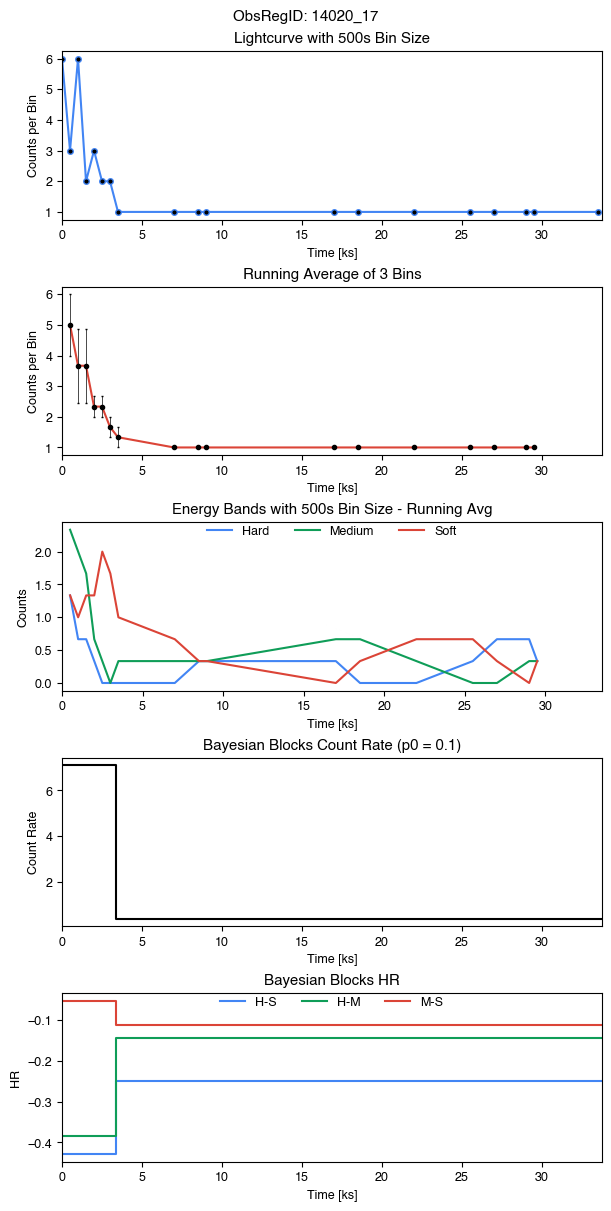

Name: 2CXO J063348.4+174924, ID: 15595-79, Date: 2012-11-28T22:34:53, Counts: 101
RA  98.45184316521068 DEC  17.823464027826628
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


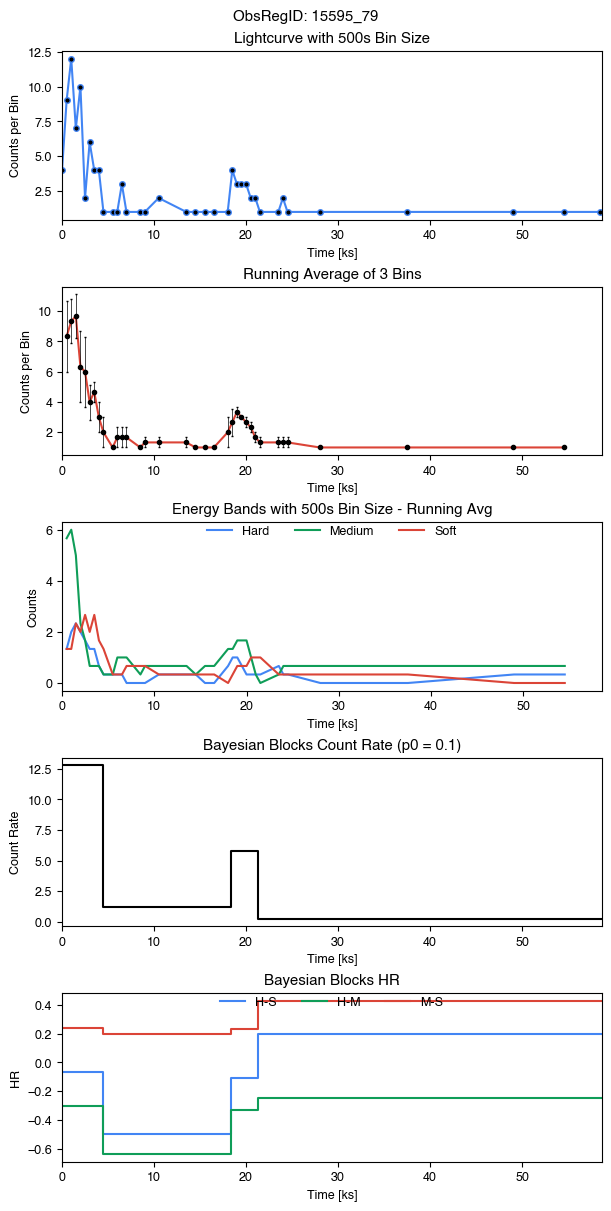

Name: 2CXO J080556.9+041703, ID: 17757-6, Date: 2015-12-28T06:39:16, Counts: 46
RA  121.48740563299066 DEC  4.284335085569118
varB  1.0 varH  nan varM  0.93 varS  0.9 varINDEX  8.0


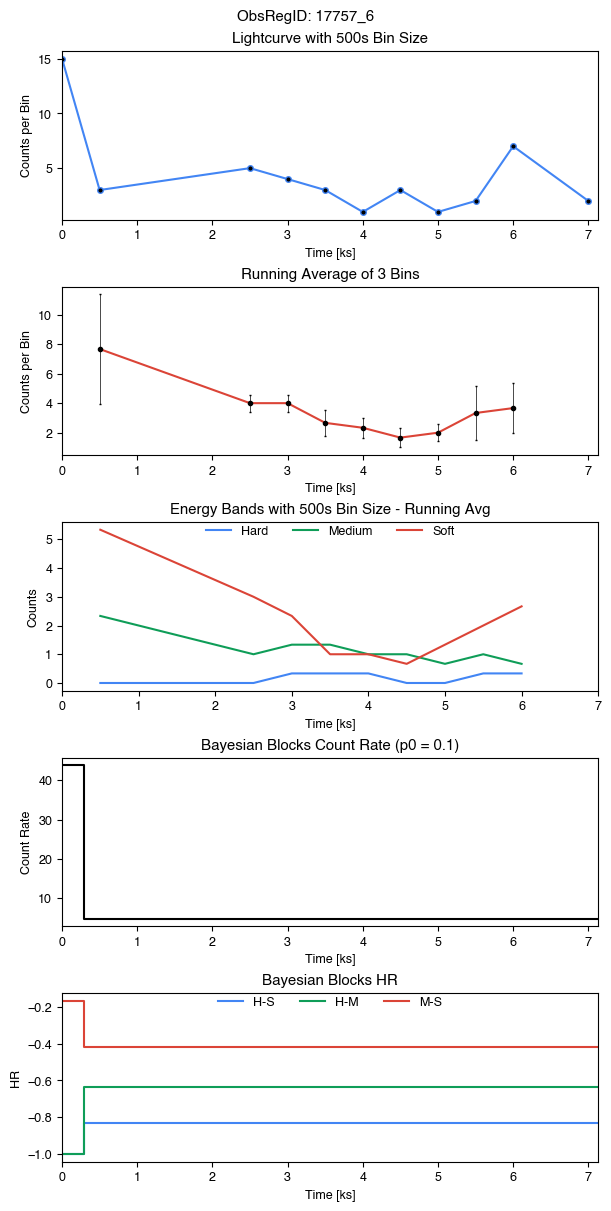

Name: 2CXO J054127.0-015210, ID: 1878-156, Date: 2001-08-08T07:02:51, Counts: 55
RA  85.36291186606456 DEC  -1.869454621418533
varB  1.0 varH  0.99 varM  1.0 varS  0.93 varINDEX  9.0


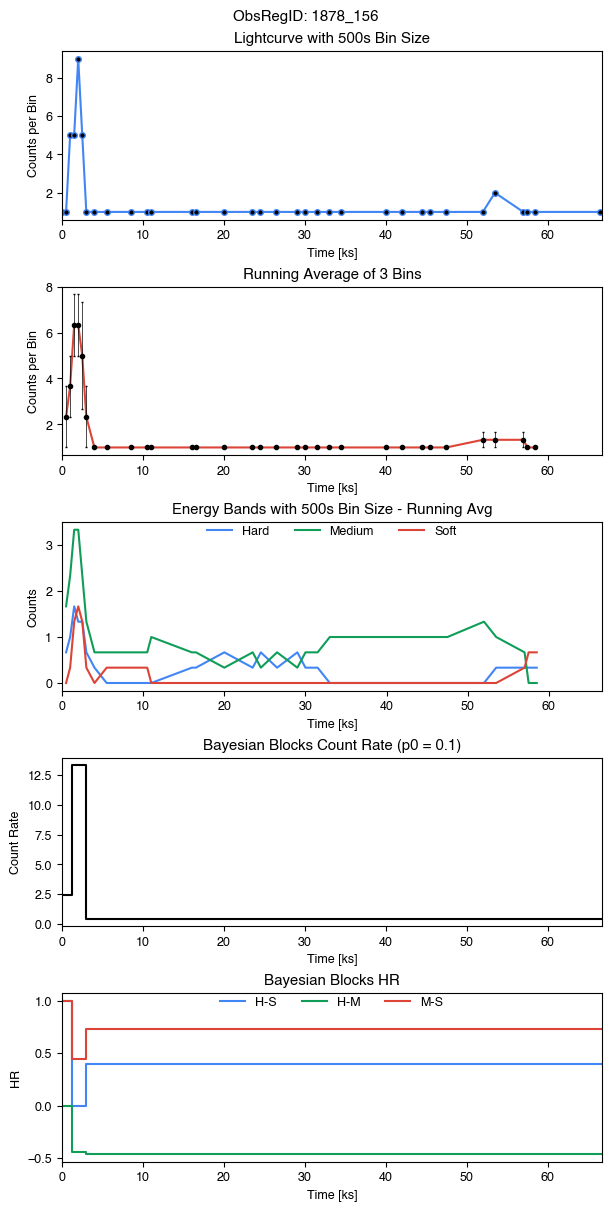

Name: 2CXO J181049.5-192830, ID: 18905-124, Date: 2017-07-19T04:52:58, Counts: 54
RA  272.7063566386697 DEC  -19.475071693568054
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


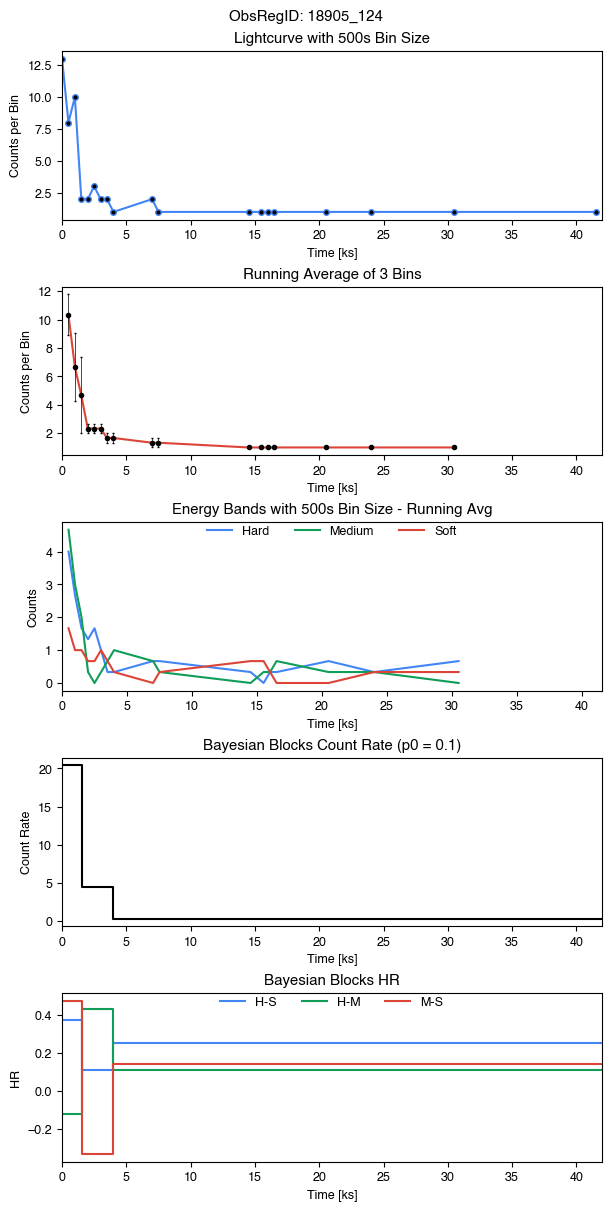

Name: 2CXO J161455.7-630844, ID: 2365-7, Date: 2001-10-21T08:57:00, Counts: 46
RA  243.7320630877257 DEC  -63.14573998389899
varB  1.0 varH  1.0 varM  1.0 varS  0.96 varINDEX  9.0


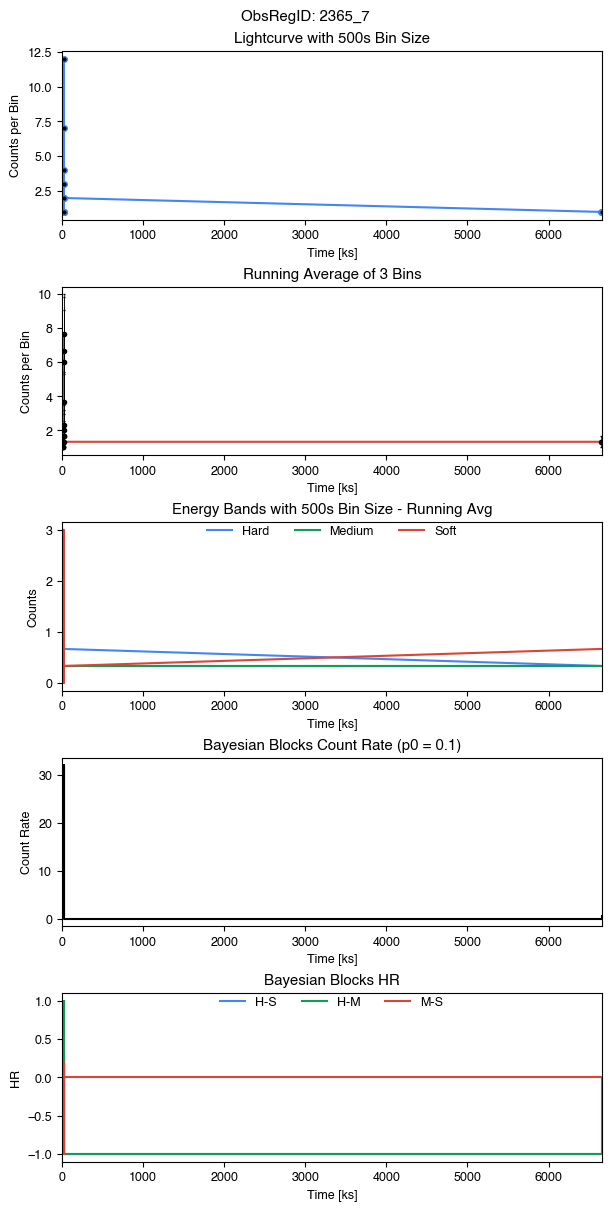

Name: 2CXO J053448.1-052238, ID: 4374-2297, Date: 2003-01-16T00:16:53, Counts: 179
RA  83.70049476962998 DEC  -5.3773905234419
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


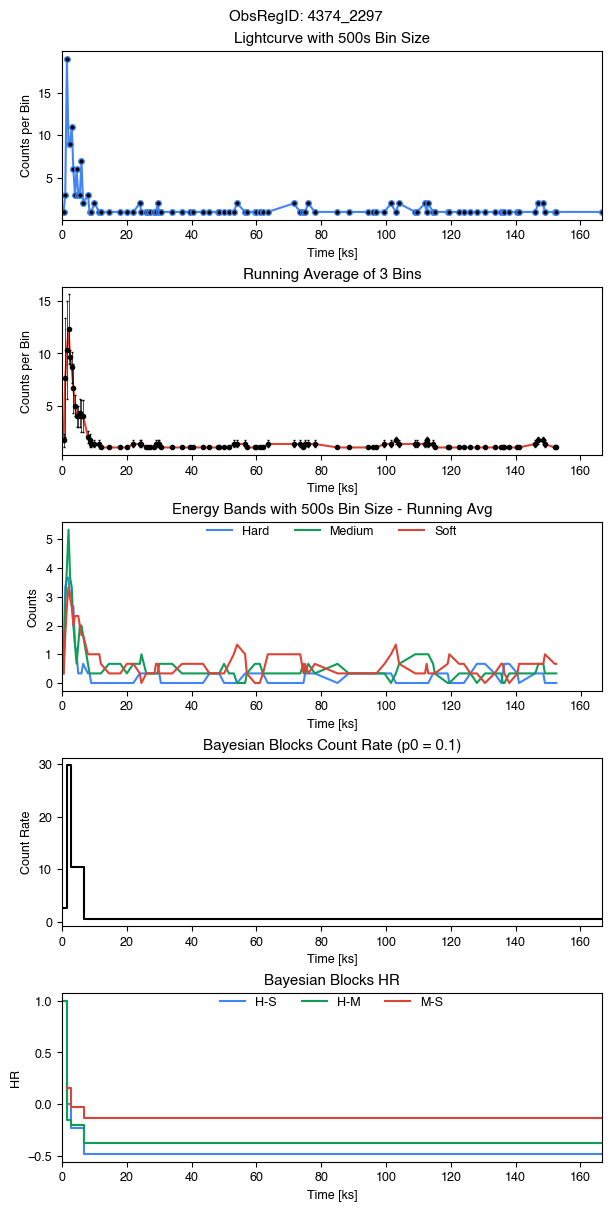

Name: 2CXO J175906.7-334639, ID: 4586-48, Date: 2004-06-25T05:33:53, Counts: 102
RA  269.778238023579 DEC  -33.77755292948796
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


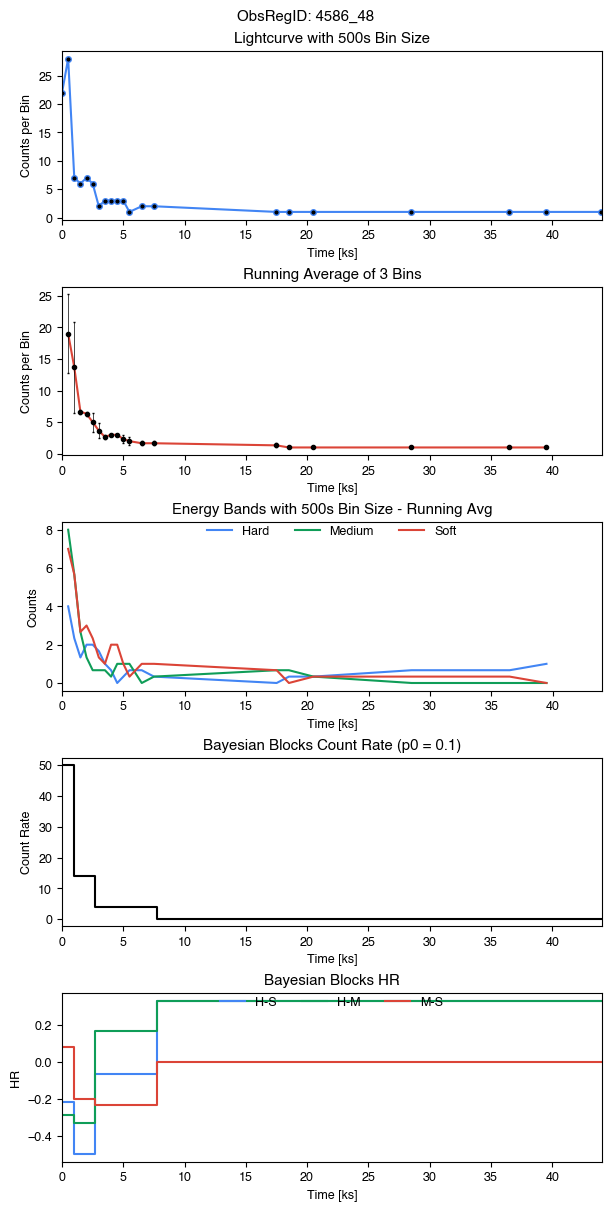

Name: 2CXO J165403.6-414343, ID: 5372-1121, Date: 2005-07-03T06:33:29, Counts: 128
RA  253.51504619929415 DEC  -41.7288796948841
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


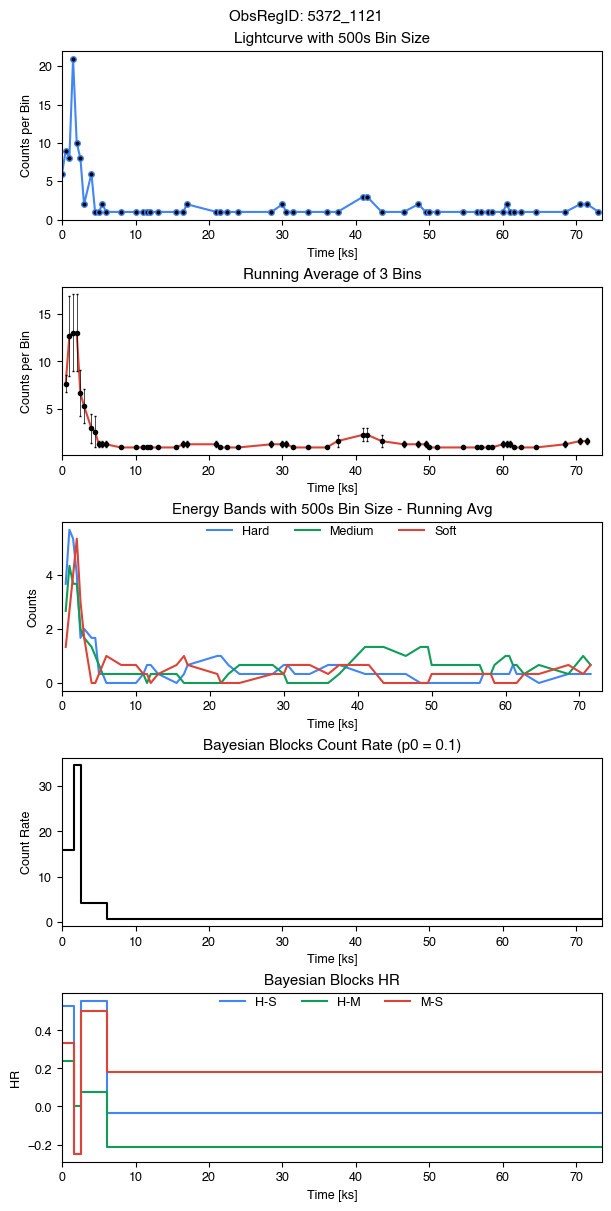

Name: 2CXO J102414.7-573951, ID: 6410-1327, Date: 2006-09-05T16:16:17, Counts: 108
RA  156.0614597374522 DEC  -57.66425079474572
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


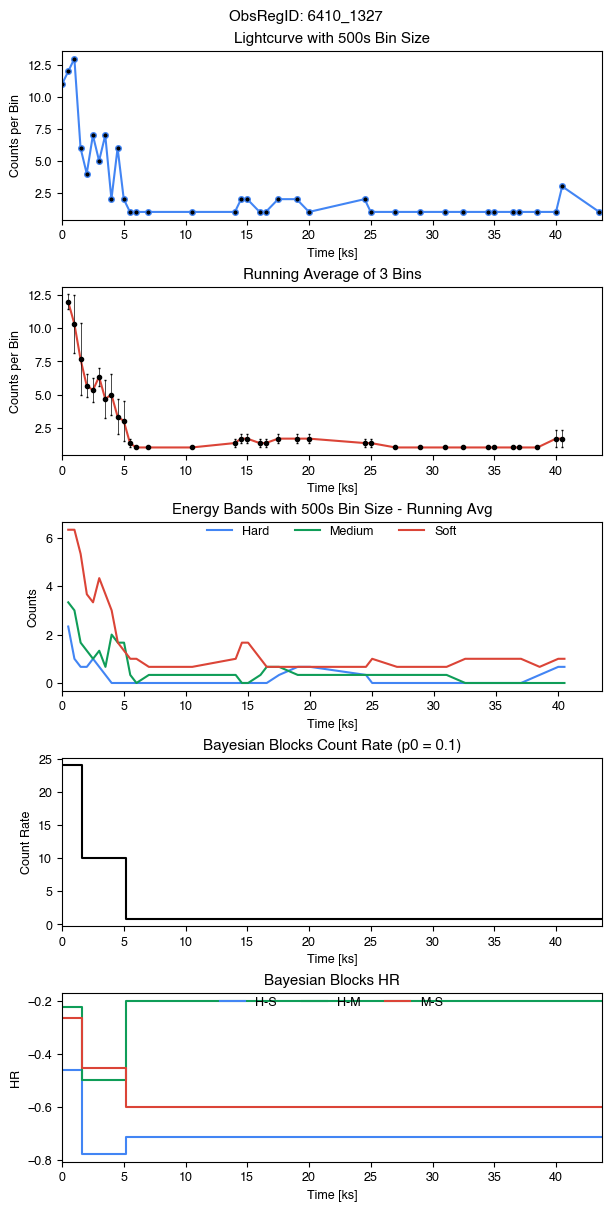

Name: 2CXO J043121.0+645029, ID: 782-20, Date: 2000-04-11T00:22:39, Counts: 45
RA  67.83790380934977 DEC  64.84153655246958
varB  1.0 varH  1.0 varM  0.99 varS  0.99 varINDEX  9.0


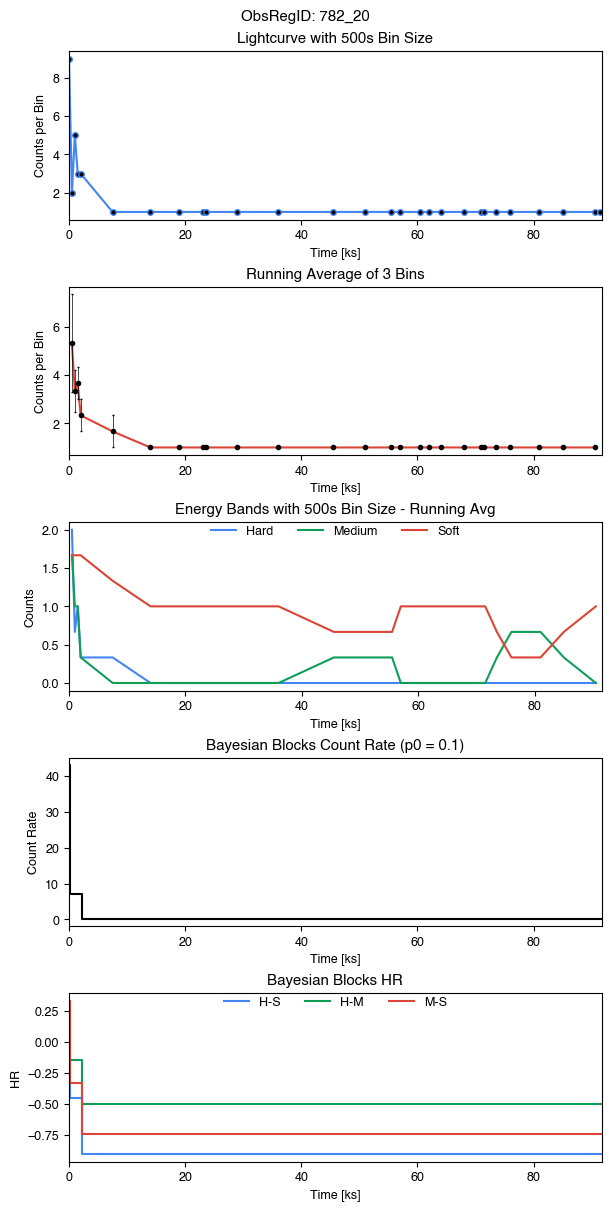

Name: 2CXO J151454.3+363933, ID: 800-47, Date: 2000-06-06T16:19:59, Counts: 75
RA  228.72635089648645 DEC  36.6593138605204
varB  0.97 varH  0.86 varM  0.5 varS  0.66 varINDEX  6.0


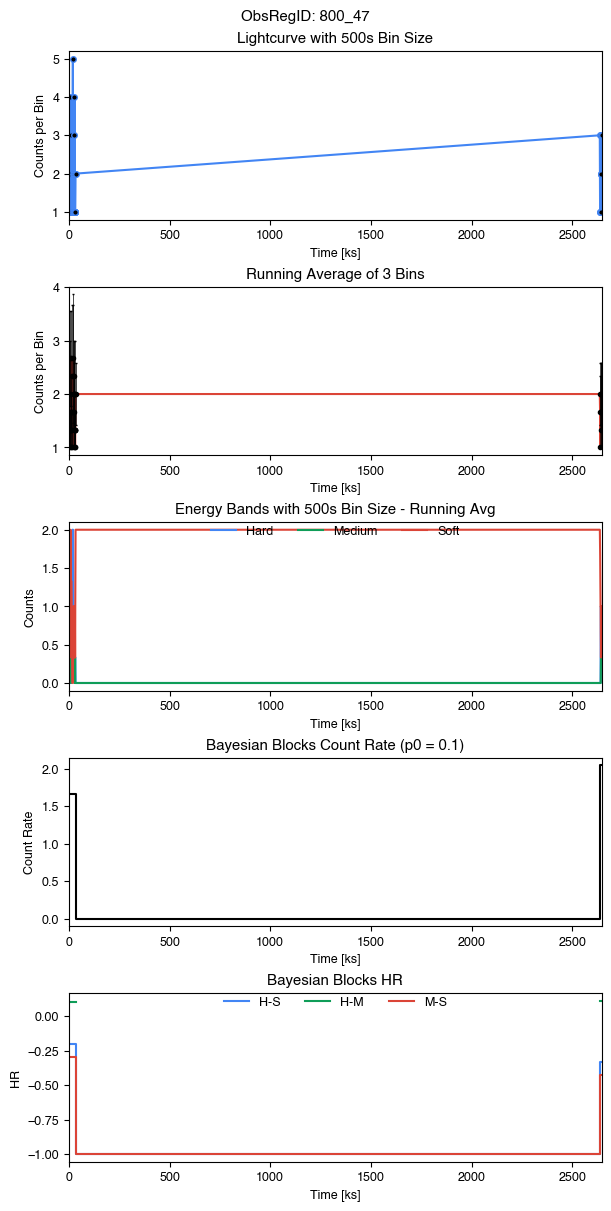

Name: 2CXO J152151.6+074650, ID: 900-27, Date: 2000-04-03T12:43:39, Counts: 76
RA  230.465410605796 DEC  7.780901524687346
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


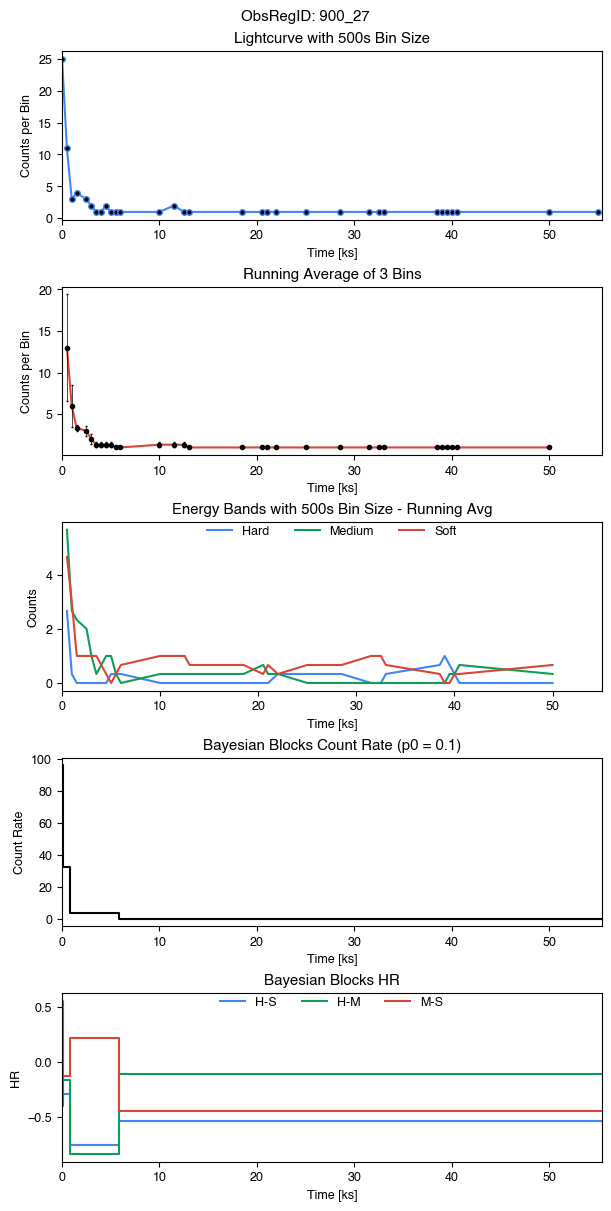

Name: 2CXO J021857.4+570839, ID: 9912-429, Date: 2009-11-11T07:35:18, Counts: 39
RA  34.73916031626504 DEC  57.14434869384045
varB  1.0 varH  0.98 varM  1.0 varS  0.85 varINDEX  8.0


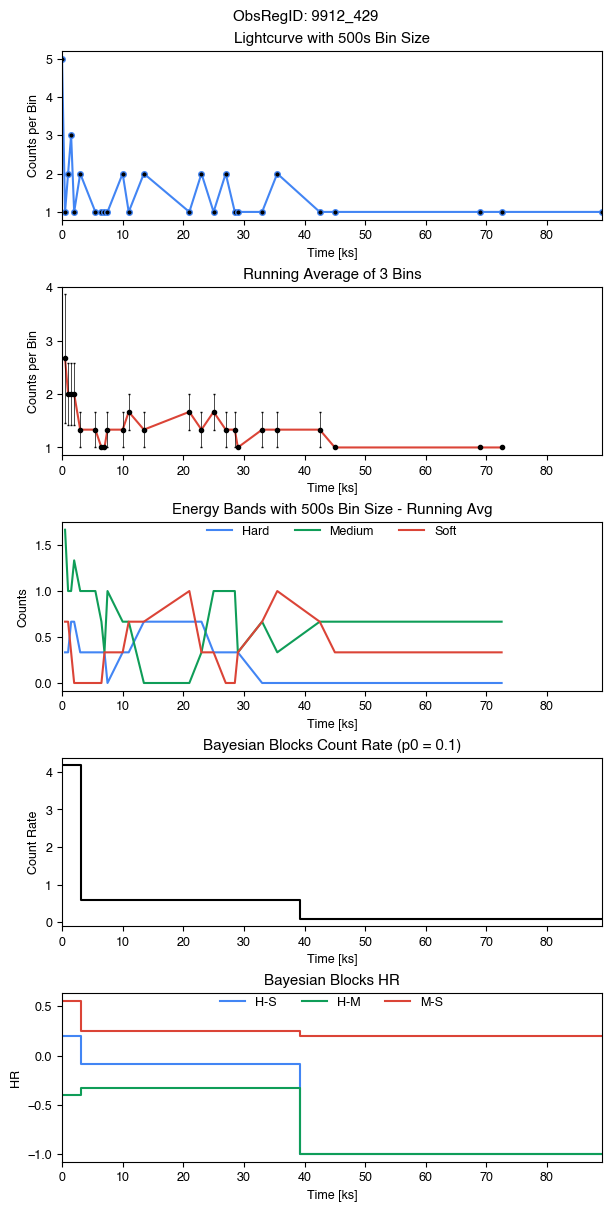

In [77]:
# ###
df_properties_anomalies = df_properties_anomalies2 # comment out for clusters
# df_select = points_in_box# comment out for clusters
df_properties_anomalies = df_properties_anomalies[df_properties_anomalies['var_index_b']>5] #COMMENT OUT
potential_anomalies = df_properties_anomalies['obsreg_id']
# potential_anomalies = df_select['obsreg_id']
print(len(potential_anomalies))
keep = potential_anomalies.values[0:100]


# keep = ['13814_86','2540_253','633_2117']
# keep = ['6442_37','11231_250','5424_145','16000_221']
# keep = ['3012_53','3744_830','4373_662','4396_2625','13117_169','13653_40','6291_253']
# keep = ['12330_2071','10135_343','11073_116','11073_116','13951_16']
# keep = potential_anomalies.values
# keep = ['9912_482']
years = range(1999,2023)
# Image producer
# keep = all_ids[50000:55000]
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in keep).groupby('obsreg_id')
for id_name, dfi in df_eventfiles_group_filtered:
    dfi.sort_values(by='time', inplace = True) 
    dfi.reset_index(drop=True, inplace = True)
    obsid = id_name.split("_")[0]
    regionid = id_name.split("_")[1]
    # Get property columns
    name = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].name.values[0]
    ra = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].ra.values[0]
    dec = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].dec.values[0]
    date = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].gti_obs.values[0] 
    var_prob_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_b.values[0]
    var_prob_h = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_h.values[0]
    var_prob_m = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_m.values[0]
    var_prob_s = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_s.values[0] 
    var_index_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_index_b.values[0]

    if any(str(year) in date for year in years):
        print(f'Name: {name}, ID: {obsid}-{regionid}, Date: {date}, Counts: {len(dfi)}')
        print('RA ', str(ra), 'DEC ', str(dec))
        print('varB ', str(round(var_prob_b,2)), 'varH ', str(round(var_prob_h,2)),'varM ', str(round(var_prob_m,2)),'varS ', str(round(var_prob_s,2)),'varINDEX ', str(var_index_b))
        lightcurveplotterNEW(dfi,id_name,500,bb_p0=0.1,band_errors=False)
        # lightcurveplotterNEW(dfi,id_name,len(dfi)/100,bb_p0=0.1,band_errors=False)
    else:
        pass
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=True)
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=False)
    # hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=True)
    #hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=False)
    # hist3Dlog(dfi,id_name,16,24,24,'minmax',True,'plasma')